In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random


In [2]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('intents.json').read()
intents = json.loads(data_file)

In [3]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [4]:
# lemmatize, lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

47 documents
9 classes ['adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'hospital_search', 'options', 'pharmacy_search', 'thanks']
88 unique lemmatized words ["'s", ',', 'a', 'adverse', 'all', 'anyone', 'are', 'awesome', 'be', 'behavior', 'blood', 'by', 'bye', 'can', 'causing', 'chatting', 'check', 'could', 'data', 'day', 'detail', 'do', 'dont', 'drug', 'entry', 'find', 'for', 'give', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'how', 'i', 'id', 'is', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'me', 'module', 'nearby', 'next', 'nice', 'of', 'offered', 'open', 'patient', 'pharmacy', 'pressure', 'provide', 'reaction', 'related', 'result', 'search', 'searching', 'see', 'show', 'suitable', 'support', 'task', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'transfer', 'up', 'want', 'what', 'which', 'with', 'you']


In [5]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


In [6]:
def create_model():
    # Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
    # equal to number of intents to predict output intent with softmax
    model = Sequential()
    model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(train_y[0]), activation='softmax'))
    # Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


In [13]:
model = create_model()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               11392     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                 585       
                                                                 
Total params: 20,233
Trainable params: 20,233
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [16]:
#fitting and saving the model 
history_1 = model.fit(np.array(train_x), 
                 np.array(train_y), 
                 epochs=200, 
                 validation_split=0.20,
                 batch_size=5, 
                 verbose=1)


ccuracy: 0.8000
Epoch 59/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1356 - accuracy: 0.9730 - val_loss: 0.5216 - val_accuracy: 0.8000
Epoch 60/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0926 - accuracy: 1.0000 - val_loss: 0.4975 - val_accuracy: 0.8000
Epoch 61/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0491 - accuracy: 0.9730 - val_loss: 0.5001 - val_accuracy: 0.8000
Epoch 62/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1492 - accuracy: 0.9459 - val_loss: 0.4929 - val_accuracy: 0.8000
Epoch 63/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0396 - accuracy: 1.0000 - val_loss: 0.4942 - val_accuracy: 0.8000
Epoch 64/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0587 - accuracy: 1.0000 - val_loss: 0.4843 - val_accuracy: 0.8000
Epoch 65/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0536 - accuracy: 1.0000 - val_loss: 0.4931 - val_accuracy: 0.8000
Epoc

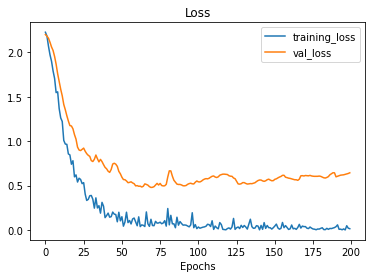

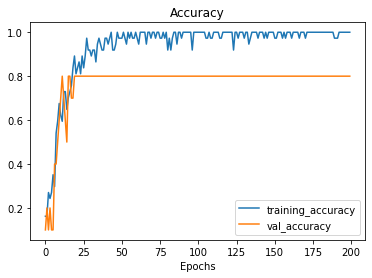

In [17]:
plot_loss_curves(history_1)

In [18]:
#saving the model 
model.save('chatbot_model.h5', history_1)
print("model created")

model created
